In [9]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

import functions

import numpy as np
np.random.seed(18)

In [5]:
al_train_ds, al_val_ds = image_dataset_from_directory(
    '../data/alzheimer/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(208, 176),
    seed=18,
    validation_split=0.2,
    subset = 'both'
)

Found 5123 files belonging to 4 classes.
Using 4099 files for training.
Using 1024 files for validation.


In [11]:
es = EarlyStopping(patience = 5)

model = Sequential()


model.add(layers.Input(shape=(208, 176, 3)))
model.add(layers.Rescaling(1./255))

#First Convolution
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#Second Convolution
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#Flatten
model.add(Flatten())
# Fully Connected
model.add(Dense(32, activation = 'relu'))
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h = model.fit(al_train_ds, validation_data = al_val_ds, epochs=50, callbacks = [es])

Epoch 1/50
129/129 [==============================] - 36s 272ms/step - loss: 1.0261 - accuracy: 0.5040 - val_loss: 0.9004 - val_accuracy: 0.5605
Epoch 2/50
129/129 [==============================] - 38s 290ms/step - loss: 0.7718 - accuracy: 0.6538 - val_loss: 0.6302 - val_accuracy: 0.7178
Epoch 3/50
129/129 [==============================] - 37s 284ms/step - loss: 0.4614 - accuracy: 0.8161 - val_loss: 0.4061 - val_accuracy: 0.8223
Epoch 4/50
129/129 [==============================] - 37s 285ms/step - loss: 0.1922 - accuracy: 0.9356 - val_loss: 0.2778 - val_accuracy: 0.8779
Epoch 5/50
129/129 [==============================] - 37s 290ms/step - loss: 0.0845 - accuracy: 0.9751 - val_loss: 0.1009 - val_accuracy: 0.9658
Epoch 6/50
129/129 [==============================] - 38s 294ms/step - loss: 0.0272 - accuracy: 0.9954 - val_loss: 0.1347 - val_accuracy: 0.9463
Epoch 7/50
129/129 [==============================] - 37s 288ms/step - loss: 0.0106 - accuracy: 0.9988 - val_loss: 0.0595 - val_ac

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 208, 176, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 206, 174, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 103, 87, 32)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 101, 85, 32)       9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 42, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 67200)            

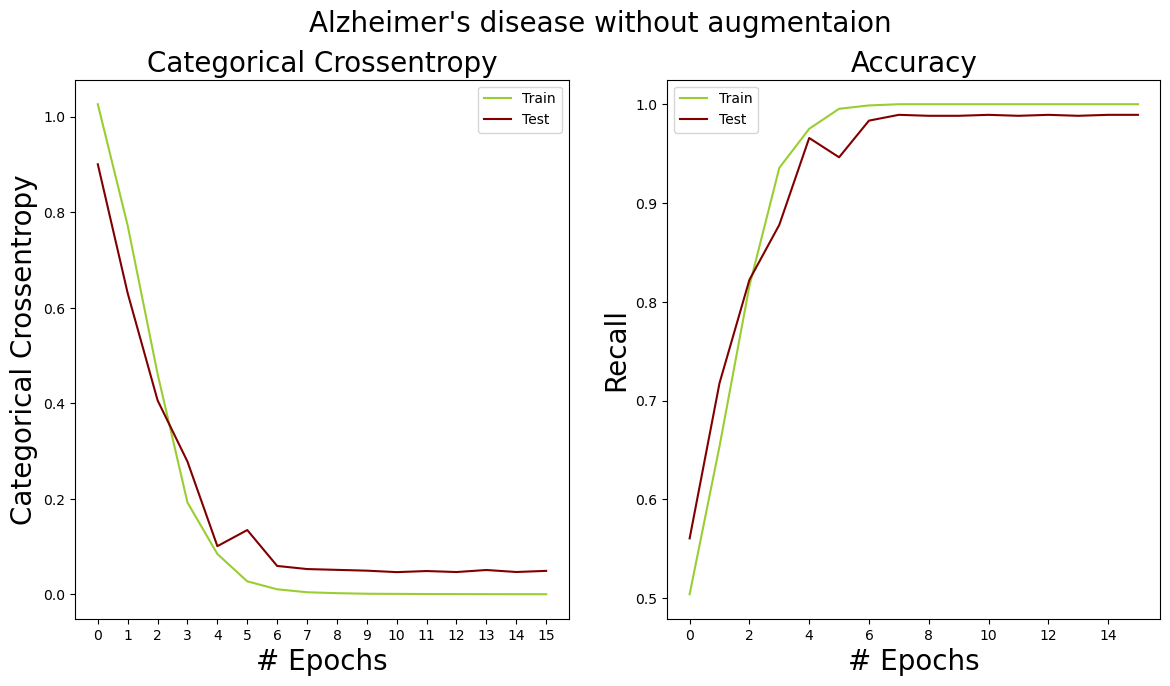

In [14]:
# Plot Crossentropy and Recall y epoch
functions.evaluation_plots(h, 'Alzheimer\'s disease without augmentaion')

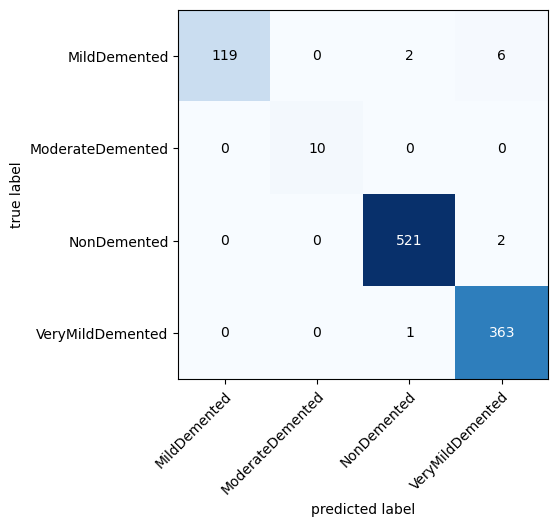

In [16]:
# Plot Confusion Matrix
functions.confusion_matrix_plot(al_val_ds, model)

The model performs suprisingly well on the validating set. I will bring separate test set to check it.

In [17]:
al_test_ds = image_dataset_from_directory(
    '../data/alzheimer/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(208, 176),
    seed=18
)

Found 1279 files belonging to 4 classes.


In [32]:
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.math import confusion_matrix

def confusion_matrix_plot(val_data, model):
    '''
    '''
    # Generate Confusion Matrix
    predictions = np.array([])
    labels =  np.array([])
    for x, y in val_data:
        predictions = np.concatenate([predictions, model.predict(x, verbose = False).argmax(axis=1)])
        labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
    acc = round(accuracy_score(labels, predictions), 4)
    print(f'Accuracy_score: {acc} \n')    

    cm = confusion_matrix(labels=labels, predictions=predictions).numpy()
    # Plot the confusion matrix
    fig, ax = plot_confusion_matrix(cm, class_names=val_data.class_names)

Accuracy_score: 0.6255 



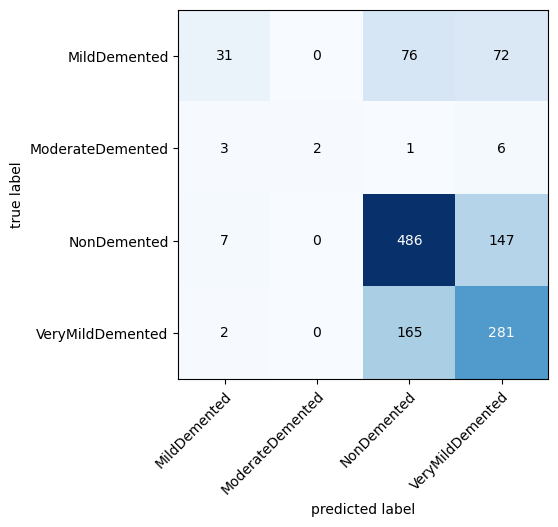

In [33]:
confusion_matrix_plot(al_test_ds, model)

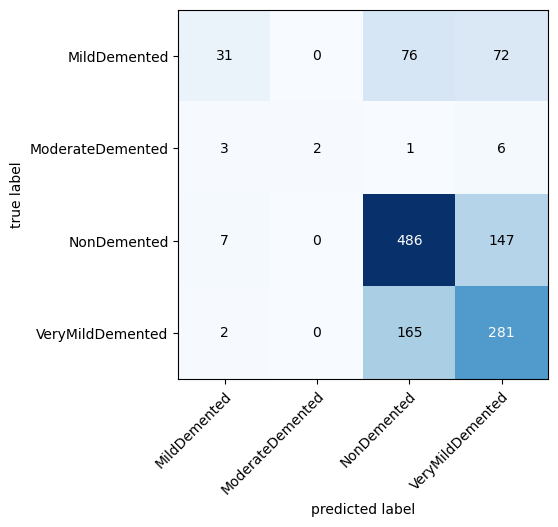

In [21]:
# Plot Confusion Matrix
functions.acc_conf_matrix(al_test_ds, model)

Surprisingly the least common  class - Moderate Demented is spot on - I will not need to do resampling. However, the model does not perform great on the test set overall, I will use augmentation to improve my model.